
🔵 Training ResNet18 (5 epochs)
Epoch 1/5 | Loss: 0.1366 | Train Acc: 95.88% | Test Acc: 98.58% | Frobenius Norm: 113.69
Epoch 2/5 | Loss: 0.0592 | Train Acc: 98.28% | Test Acc: 98.64% | Frobenius Norm: 114.97
Epoch 3/5 | Loss: 0.0460 | Train Acc: 98.66% | Test Acc: 98.62% | Frobenius Norm: 116.63
Epoch 4/5 | Loss: 0.0412 | Train Acc: 98.76% | Test Acc: 98.61% | Frobenius Norm: 118.85
Epoch 5/5 | Loss: 0.0334 | Train Acc: 99.02% | Test Acc: 98.86% | Frobenius Norm: 121.37

🔴 Training ResNet18 (50 epochs)
Epoch 1/50 | Loss: 0.1324 | Train Acc: 96.02% | Test Acc: 96.27% | Frobenius Norm: 113.63
Epoch 2/50 | Loss: 0.0590 | Train Acc: 98.25% | Test Acc: 98.21% | Frobenius Norm: 114.94
Epoch 3/50 | Loss: 0.0476 | Train Acc: 98.59% | Test Acc: 98.84% | Frobenius Norm: 116.65
Epoch 4/50 | Loss: 0.0365 | Train Acc: 98.93% | Test Acc: 98.74% | Frobenius Norm: 118.56
Epoch 5/50 | Loss: 0.0326 | Train Acc: 99.10% | Test Acc: 99.10% | Frobenius Norm: 121.21
Epoch 6/50 | Loss: 0.0299 | Train Acc: 9

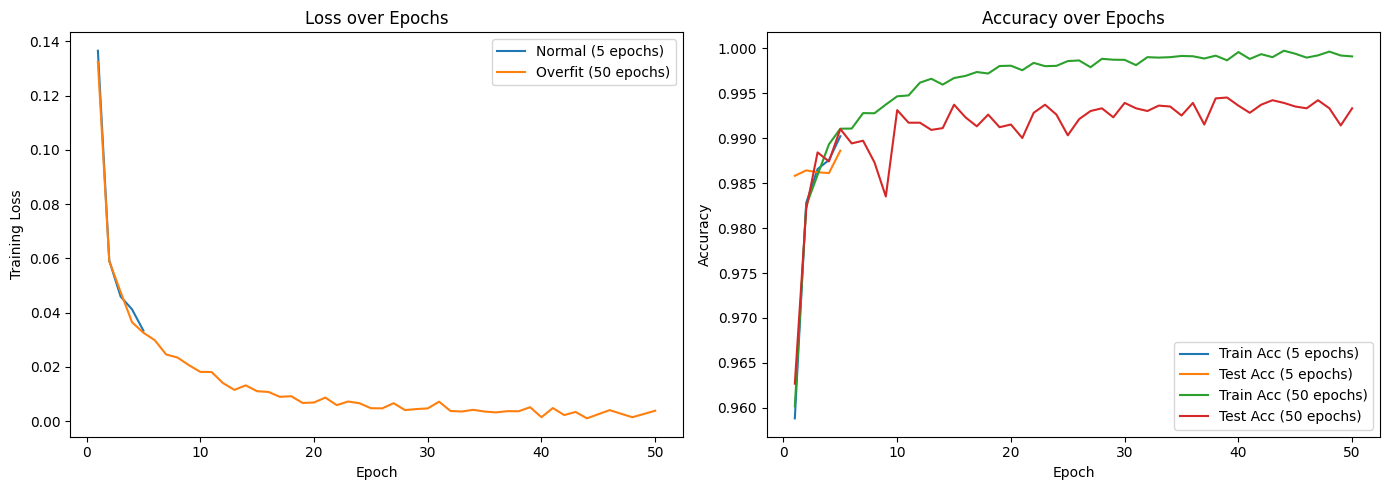

Final Frobenius Norms:
🔵 Normal: 121.37
🔴 Overfit: 367.55


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

def get_resnet18(num_classes=10):
    model = models.resnet18(weights=None)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

def compute_frobenius_norm(model):
    weights = [param for name, param in model.named_parameters() if 'weight' in name]
    all_weights = torch.cat([w.flatten() for w in weights])
    return torch.norm(all_weights, p=2).item()

def train_model(model, optimizer, train_loader, test_loader, epochs=5, device='cpu'):
    criterion = nn.CrossEntropyLoss()
    model.to(device)
    train_loss, train_acc, test_acc, frob_norms = [], [], [], []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct_train, total_train = 0, 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == targets).sum().item()
            total_train += targets.size(0)

        epoch_train_loss = total_loss / len(train_loader)
        epoch_train_acc = correct_train / total_train
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_acc)

        model.eval()
        correct_test, total_test = 0, 0
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                correct_test += (predicted == targets).sum().item()
                total_test += targets.size(0)

        epoch_test_acc = correct_test / total_test
        test_acc.append(epoch_test_acc)
        frob_norms.append(compute_frobenius_norm(model))

        print(f"Epoch {epoch+1}/{epochs} | Loss: {epoch_train_loss:.4f} | "
              f"Train Acc: {epoch_train_acc*100:.2f}% | Test Acc: {epoch_test_acc*100:.2f}% | "
              f"Frobenius Norm: {frob_norms[-1]:.2f}")

    return train_loss, train_acc, test_acc, frob_norms

# Data loading
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Train model (5 epochs)
print("\n🔵 Training ResNet18 (5 epochs)")
model_normal = get_resnet18()
optimizer_normal = optim.Adam(model_normal.parameters(), lr=0.001)
normal_loss, normal_train_acc, normal_test_acc, normal_frob = train_model(
    model_normal, optimizer_normal, train_loader, test_loader, epochs=5, device=device
)

# Train model (50 epochs)
print("\n🔴 Training ResNet18 (50 epochs)")
model_overfit = get_resnet18()
optimizer_overfit = optim.Adam(model_overfit.parameters(), lr=0.001)
overfit_loss, overfit_train_acc, overfit_test_acc, overfit_frob = train_model(
    model_overfit, optimizer_overfit, train_loader, test_loader, epochs=50, device=device
)

# Plotting
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, 6), normal_loss, label="Normal (5 epochs)")
plt.plot(range(1, 51), overfit_loss, label="Overfit (50 epochs)")
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, 6), normal_train_acc, label="Train Acc (5 epochs)")
plt.plot(range(1, 6), normal_test_acc, label="Test Acc (5 epochs)")
plt.plot(range(1, 51), overfit_train_acc, label="Train Acc (50 epochs)")
plt.plot(range(1, 51), overfit_test_acc, label="Test Acc (50 epochs)")
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

print(f"Final Frobenius Norms:\n🔵 Normal: {normal_frob[-1]:.2f}\n🔴 Overfit: {overfit_frob[-1]:.2f}")
